# Capco RTR Fraud Detection Project

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score, roc_curve
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## Loading Data

In [2]:
# load data
training_data = pd.read_csv('sample.csv')
test_data = pd.read_csv('test.csv')

In [119]:
training_data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.247824,6.425853,-6.485658,-8.241462,NaN,0.03%,Tuesday,-9.808905,4.753455,2.537819,...,0.592543,14.967527,6.691044,-0.275572,2.518542,4.637431,-14.296510,1.898115,-1.225228,0
1,2.623274,-2.808263,5.321746,-2.437653,0.614041,0.02%,Wednesday,10.710053,1.608882,-2.027541,...,-1.712788,-3.638637,-2.256492,2.703101,1.760729,2.660614,1.182922,-3.203078,0.711018,0
2,-5.460551,5.997701,-4.614194,-6.035128,-1.986438,-0.0%,Tuesday,-3.364649,-2.493473,1.429913,...,2.206956,7.292558,10.095556,1.601155,1.710645,-12.519434,-5.261707,2.032666,-6.445528,0
3,1.566307,-0.080517,0.064754,6.063193,-2.253075,0.0%,Thurday,-6.111982,-1.796377,-3.169510,...,-3.841669,5.189840,10.291069,-3.642396,0.674300,-1.104317,-3.922342,-0.613947,7.275179,0
4,0.750715,15.656095,-6.778600,11.251037,-0.308200,0.0%,Wednesday,2.498892,-0.323229,-2.624680,...,8.933781,-7.295794,-11.246059,-4.876594,3.395415,-2.646844,-5.273267,-5.259536,-3.240523,0


## Data Exploration
According to correlation matrix, the numeric columns have low correlation.
The dataset has been transformed by principle component analysis.

In [120]:
# the shape of the training the test dataset 
print("the shape of the training dataset is ", training_data.shape)
print("the shape of the test dataset is ", test_data.shape)

the shape of the training dataset is  (8000, 101)
the shape of the test dataset is  (2000, 100)


In [121]:
# extract the categorical variables columns
categorical = [cname for cname in training_data.columns
              if training_data[cname].dtype == "object"]
print("categorical variables columns are", categorical)

categorical_df = training_data[['x5', 'x6', 'x20', 'x27', 'x49', 'x57']]

categorical variables columns are ['x5', 'x6', 'x20', 'x27', 'x49', 'x57']


In [122]:
# list the unique values in the above variable
for cname in categorical:
    print( "variable", cname ,":", training_data[cname].unique())

variable x5 : ['0.03%' '0.02%' '-0.0%' '0.0%' '-0.01%' '-0.02%' '0.01%' '-0.03%' nan
 '-0.04%' '0.04%']
variable x6 : ['Tuesday' 'Wednesday' 'Thurday' nan 'Monday' 'Friday']
variable x20 : ['Aug' 'Jul' 'Jun' 'May' 'Apr' 'Sept' 'Oct' nan 'Mar' 'Feb' 'Nov' 'Dec'
 'Jan']
variable x27 : ['Afternoon' 'Evening' 'Night' 'Morning' nan]
variable x49 : [False True nan]
variable x57 : ['$1578.34' '$767.76' '$931.06' ... '$220.59' '$467.47' '$-598.35']


## Data Preparation

### Split the variable into predictor and input variable

In [3]:
Y = training_data['y']
training_data = training_data.drop(['y'],axis=1)

### Convert categorical variable to numeric variable

In [4]:
# convert the percentage column x5 and currency column x57 into numeric data
training_data['x5'] = training_data['x5'].str.rstrip('%').astype('float') / 100
training_data['x57'] = training_data['x57'].replace('[\$,)]','',regex=True).replace('[(]','-',regex=True).astype(float)

test_data['x5'] = test_data['x5'].str.rstrip('%').astype('float') / 100
test_data['x57'] = test_data['x57'].replace('[\$,)]','',regex=True).replace('[(]','-',regex=True).astype(float)

### One-Hot encoding on categorical variables

In [5]:
training_data_cat_df = training_data[['x6', 'x20', 'x27', 'x49']]
test_data_cat_df = test_data[['x6', 'x20', 'x27', 'x49']]
training_data_cat_df_2 = pd.get_dummies(training_data_cat_df, drop_first=True)
test_data_cat_df_2 = pd.get_dummies(test_data_cat_df, drop_first=True)
training_data = pd.concat([training_data, training_data_cat_df_2], axis=1)
test_data = pd.concat([test_data, test_data_cat_df_2], axis=1)

In [8]:
training_data = training_data.drop(['x6', 'x20', 'x27', 'x49'], axis=1)
test_data = test_data.drop(['x6', 'x20', 'x27', 'x49'], axis=1)

In [9]:
encoded_x = training_data

### Encode predictor values as integers

In [10]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

## XGBOOST Model Training

### The final fit model on test set 

In [11]:
# set the scaling weight to deal with imbalanced dataset problem
ratio = float(np.sum( Y == 0)) / np.sum( Y == 1)

In [12]:
# split the data into train and test sets 

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(encoded_x, label_encoded_y, test_size=test_size, random_state=seed)


In [13]:
# fit model no training data
model = XGBClassifier(scale_pos_weight = 18.5,max_depth=3, 
                      gamma = 0.2, min_child_weight=5,
                      reg_lambda = 0.05, learning_rate = 0.019,
                      max_delta_step = 1
                    )
model.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
recall = recall_score(y_test, predictions)
print("Recall: %.2f%%" % (recall * 100.0))
precision = precision_score(y_test, predictions)
print("Precision: %.2f%%" % (precision * 100.0))
roc_auc = roc_auc_score(y_test, predictions)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.019,
       max_delta_step=1, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.05, scale_pos_weight=18.5, seed=None, silent=True,
       subsample=1)
Accuracy: 86.31%
Recall: 87.50%
Precision: 25.09%
ROC_AUC: 86.88%


In [14]:
# Plot the confusion matrix

pd.crosstab(pd.Series(y_test, name = 'Actual'),
            pd.Series(predictions, name = 'Predicted'),
            margins = True)

Predicted,0,1,All
Actual,,,
0,1311,209,1520
1,10,70,80
All,1321,279,1600


### Visualiza the Xgboost ROC Curve

In [15]:
test_data_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_data_pred_prob[:,1], pos_label=1)

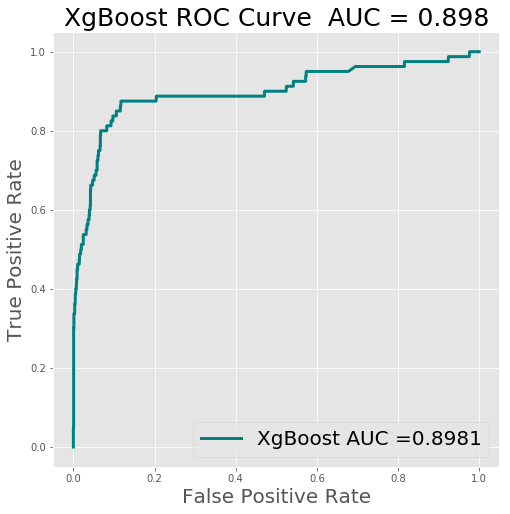

In [16]:
plt.figure(figsize=(8,8))
auc = round(np.trapz(tpr, fpr),4)
plt.plot(fpr, tpr, label='XgBoost AUC =' + str(auc), lw = 3, color = 'teal')
plt.title("XgBoost ROC Curve  AUC = 0.898" , fontsize= 25)
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(prop ={'size':20})
plt.show()

## XgBoost Parameter Fine Tuning

#### Step 1: Fix learning rate and number of estimators for tuning tree-based model

In [18]:

# split the data into train and test sets 
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(encoded_x, label_encoded_y, test_size=test_size, random_state=seed)

# fit model to training data
model1 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', scale_pos_weight=18.5,seed=27)

model1.fit(X_train, y_train)
print(model1)
# make predictions for test data
y_pred = model1.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
recall = recall_score(y_test, predictions)
print("Recall: %.2f%%" % (recall * 100.0))
roc_auc = roc_auc_score(y_test, predictions)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=18.5, seed=27,
       silent=True, subsample=0.8)
Accuracy: 96.56%
Recall: 48.75%
ROC_AUC: 73.91%


Note: 
Since the dataset is an imbalanced dataset,
scale_pos_weight is set to be the ratio of negative cases / positive cases
in predictor variable to control the balance.

#### Step 2: Tune max_depth and min_child_weight

In [ ]:
bst_grid = GridSearchCV(
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='roc_auc'
)

In [31]:
param_test2 = {
    'min_child_weight':[1,3,5]
}

params_fixed = {
    'objective':'binary:logistic',
    'gamma':0, 
    'max_depth':3,
    'subsample' : 0.8, 
    'colsample_bytree' : 0.8,
    'scale_pos_weight':18.5
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        cv=cv)

gsearch2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=18.5, seed=342,
       silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [1, 3, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [32]:
gsearch2.best_params_, gsearch2.best_score_

({'min_child_weight': 5}, 0.9320438566429626)

#### Step3: Tune Gamma

In [17]:

param_test3 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}

params_fixed = {
    'objective':'binary:logistic',
    'min_child_weight':5, 
    'max_depth':3,
    'subsample' : 0.8, 
    'colsample_bytree' : 0.8,
    'scale_pos_weight':18.5
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        cv=cv)

gsearch3.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=18.5, seed=342,
       silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9324278521152598)

#### Step 4: Tune subsample and colsample_bytree

In [21]:

param_test4 = { 
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

params_fixed = {
    'objective':'binary:logistic',
    'gamma':0.2,
    'min_child_weight':5, 
    'max_depth':3,
    'scale_pos_weight':18.5
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        cv=cv)

gsearch4.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=18.5, seed=7,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.9327429049549849)

### Note
I use the default parameter in colsample_bytree and subsample
since they perform better.

#### Step 5. Tune the regularization

In [33]:

param_test5 = { 
    'reg_lambda':[1e-2, 0.05,0.1, 0.5, 0.8, 0.9, 1] 
}

params_fixed = {
    'objective':'binary:logistic',
    'gamma':0.2,
    'min_child_weight':5, 
    'max_depth':3,
    'scale_pos_weight':18.5
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        cv=cv)

gsearch5.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=18.5, seed=7,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'reg_lambda': [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_lambda': 0.05}, 0.9339829088488238)

#### 6. Tune the learning rate

In [39]:

param_test6 = { 
    'learning_rate':[i/1000.0 for i in range(5,20,2)] 
}

params_fixed = {
    'objective':'binary:logistic',
    'gamma':0.2,
    'min_child_weight':5, 
    'max_depth':3,
    'scale_pos_weight':18.5,
    'reg_lambda': 0.05
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        cv=cv)

gsearch6.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.05, scale_pos_weight=18.5, seed=7,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
gsearch6.best_params_, gsearch6.best_score_

({'learning_rate': 0.019}, 0.9225224112269254)

#### Step7 Tune the max_delta_step

In [43]:

param_test7 = { 
    'max_delta_step':[1,3,5,7,9]
}

params_fixed = {
    'objective':'binary:logistic',
    'gamma':0.2,
    'min_child_weight':5, 
    'max_depth':3,
    'scale_pos_weight':18.5,
    'reg_lambda': 0.05,
    'learning_rate' : 0.019
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(**params_fixed, seed=seed), 
                        param_grid = param_test7, 
                        scoring='roc_auc',
                        cv=cv)

gsearch7.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.019,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.05, scale_pos_weight=18.5, seed=7, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_delta_step': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [44]:
gsearch7.best_params_, gsearch6.best_score_

({'max_delta_step': 1}, 0.9225224112269254)

## Make prediction for the test dataset
 - using XGboost Model

In [108]:
test_data_pred = model.predict(test_data)
test_data_pred_prob = model.predict_proba(test_data)
test_data_pred_df = pd.DataFrame(data=test_data_pred_prob)
test_data_pred_df.to_csv("xgboost_prob.csv")

## Anomaly Detection
Using Anomaly Detection to get the anomaly score as a complementary part in the combined anomaly probability. Isolation forest and Local outlier Factor are two good ways to get anomaly scores.

Anomaly Detection could identify new attack vector and learn quickly.

### Isolation Forest

In [24]:
from sklearn.ensemble import IsolationForest
# Fill in the missing value with 0
IF_X = encoded_x.fillna(0)
test_data = test_data.fillna(0)

# number of fraud and proportion
anomaly_rate = Y[Y== 1].count() / Y.shape[0]

In [26]:
from sklearn.ensemble import IsolationForest

clf_iforest = IsolationForest(behaviour = 'new',
                          max_samples="auto", n_estimators = 100,
                          random_state=42, contamination = anomaly_rate)
clf_iforest.fit(IF_X, label_encoded_y)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.054875,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=42, verbose=0)

In [27]:
y_pred = clf_iforest.predict(test_data)
y_pred = -(y_pred -1)/2
y_score = clf_iforest.decision_function(test_data)
y_score = 0.5 - y_score
print("The predicted class: ", y_pred)
print("The predicted anomaly score: ", y_score)

The predicted class:  [0. 0. 0. ... 0. 0. 0.]
The predicted anomaly score:  [0.46071353 0.47753914 0.49409575 ... 0.47538655 0.48436812 0.45628751]


#### the anomaly score represents the degree of anomaly
anomaly scores > 0.5 are considered indicators of outliers.

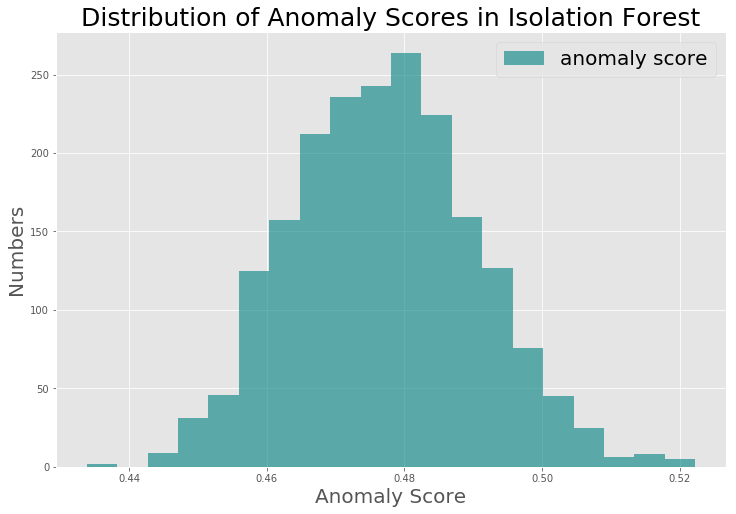

In [31]:
plt.figure(figsize=(12,8))
plt.hist(y_score, bins=20, label="anomaly score", color ='Teal', alpha = 0.6)
plt.title("Distribution of Anomaly Scores in Isolation Forest", fontsize= 25)
plt.xlabel('Anomaly Score', fontsize = 20)
plt.ylabel('Number', fontsize = 20)
plt.legend(prop ={'size':20})
plt.savefig('Anomaly_Score.png')
#plt.show()

In [105]:
np.savetxt("IForest.csv", y_score, delimiter=",")

### Local Outlier Factor

In [144]:
from sklearn.neighbors import LocalOutlierFactor
np.random.seed(42)
clf_lof = LocalOutlierFactor(contamination = 0.054875, n_neighbors = 20)
y_pred = clf_lof.fit_predict(IF_X)

In [145]:
# degree of anomaly
X_scores = clf_lof.negative_outlier_factor_

In [146]:
X_scores

array([-1.03093269, -0.99767294, -1.01674874, ..., -0.98405029,
       -1.01064421, -0.99253561])

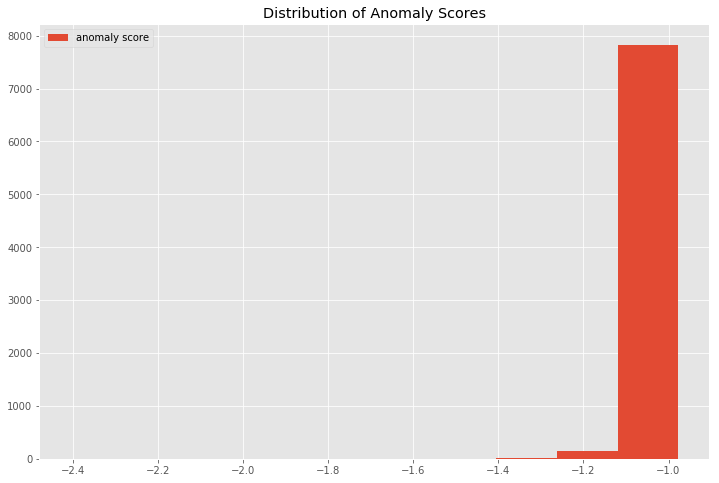

In [147]:
plt.figure(figsize=(12,8))
plt.hist(X_scores, label="anomaly score")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.show()